### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 印出網路結構
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         7

In [9]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Epoch 1/150
27/27 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00001: val_loss improved from inf to 0.00222, saving model to best_weights.h5
27/27 [==============================] - 0s 17ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 2/150
22/27 [=======================>......] - ETA: 0s - loss: 0.0017
Epoch 00002: val_loss improved from 0.00222 to 0.00191, saving model to best_weights.h5
27/27 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 3/150
22/27 [=======================>......] - ETA: 0s - loss: 0.0013
Epoch 00003: val_loss did not improve from 0.00191
27/27 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 4/150
26/27 [===========================>..] - ETA: 0s - loss: 0.0012
Epoch 00004: val_loss did not improve from 0.00191
27/27 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/150
26/27 [===========================>..] - ETA: 0s - loss: 0.0

Epoch 35/150
22/27 [=======================>......] - ETA: 0s - loss: 2.0408e-04
Epoch 00035: val_loss did not improve from 0.00074
27/27 [==============================] - 0s 8ms/step - loss: 2.0401e-04 - val_loss: 7.6971e-04
Epoch 36/150
25/27 [==========================>...] - ETA: 0s - loss: 2.0523e-04
Epoch 00036: val_loss did not improve from 0.00074
27/27 [==============================] - 0s 8ms/step - loss: 2.0513e-04 - val_loss: 7.5558e-04
Epoch 37/150
24/27 [=========================>....] - ETA: 0s - loss: 2.0831e-04
Epoch 00037: val_loss did not improve from 0.00074
27/27 [==============================] - 0s 8ms/step - loss: 2.0646e-04 - val_loss: 8.1831e-04
Epoch 38/150
27/27 [==============================] - ETA: 0s - loss: 2.0244e-04
Epoch 00038: val_loss did not improve from 0.00074
27/27 [==============================] - 0s 10ms/step - loss: 2.0244e-04 - val_loss: 7.6610e-04
Epoch 39/150
27/27 [==============================] - ETA: 0s - loss: 2.0058e-04
Epoch 0003

22/27 [=======================>......] - ETA: 0s - loss: 1.3698e-04
Epoch 00070: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 10ms/step - loss: 1.3932e-04 - val_loss: 7.4242e-04
Epoch 71/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3963e-04
Epoch 00071: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.3898e-04 - val_loss: 7.3116e-04
Epoch 72/150
22/27 [=======================>......] - ETA: 0s - loss: 1.3505e-04
Epoch 00072: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.3483e-04 - val_loss: 7.8134e-04
Epoch 73/150
21/27 [======================>.......] - ETA: 0s - loss: 1.3572e-04
Epoch 00073: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.3526e-04 - val_loss: 7.8369e-04
Epoch 74/150
22/27 [=======================>......] - ETA: 0s - loss: 1.3796e-04
Epoch 00074: val_loss d

21/27 [======================>.......] - ETA: 0s - loss: 1.0426e-04
Epoch 00106: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.0404e-04 - val_loss: 7.9850e-04
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 1.0483e-04
Epoch 00107: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.0483e-04 - val_loss: 7.5615e-04
Epoch 108/150
22/27 [=======================>......] - ETA: 0s - loss: 1.0162e-04
Epoch 00108: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.0146e-04 - val_loss: 7.5966e-04
Epoch 109/150
27/27 [==============================] - ETA: 0s - loss: 1.0148e-04
Epoch 00109: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 1.0148e-04 - val_loss: 7.6664e-04
Epoch 110/150
21/27 [======================>.......] - ETA: 0s - loss: 1.0376e-04
Epoch 00110: val_los

Epoch 142/150
21/27 [======================>.......] - ETA: 0s - loss: 8.7782e-05
Epoch 00142: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 8.6947e-05 - val_loss: 7.7872e-04
Epoch 143/150
27/27 [==============================] - ETA: 0s - loss: 8.8567e-05
Epoch 00143: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 8.8567e-05 - val_loss: 7.6899e-04
Epoch 144/150
21/27 [======================>.......] - ETA: 0s - loss: 8.8206e-05
Epoch 00144: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 8.6658e-05 - val_loss: 7.6010e-04
Epoch 145/150
21/27 [======================>.......] - ETA: 0s - loss: 8.2313e-05
Epoch 00145: val_loss did not improve from 0.00071
27/27 [==============================] - 0s 9ms/step - loss: 8.2361e-05 - val_loss: 7.4610e-04
Epoch 146/150
25/27 [==========================>...] - ETA: 0s - loss: 8.0896e-05
Epoch 

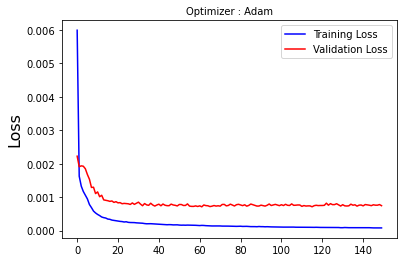

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [13]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

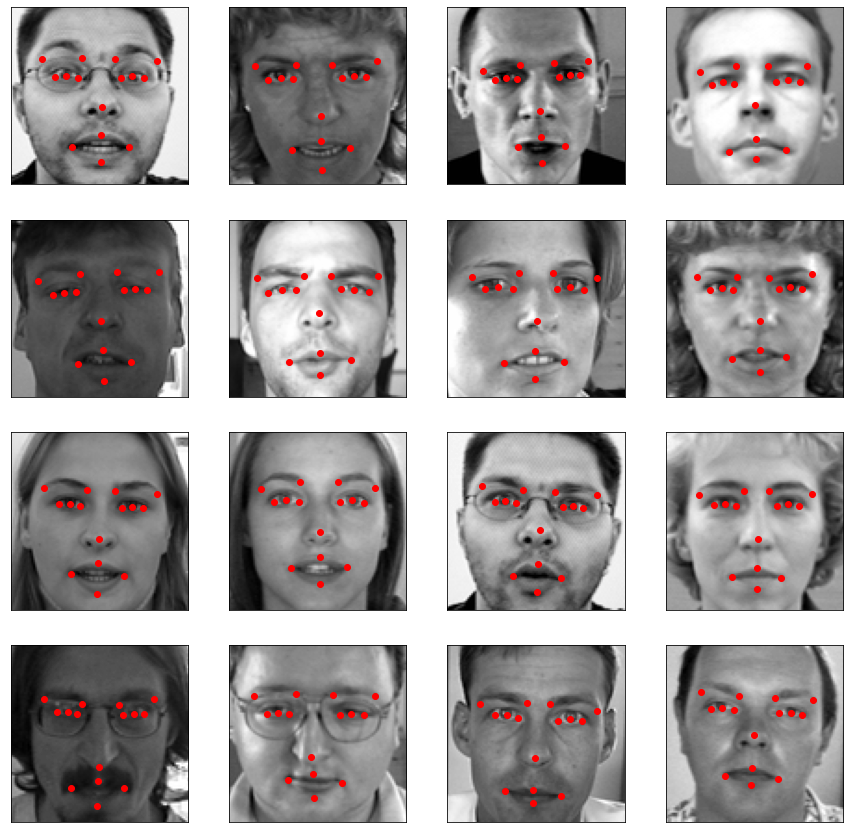

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [15]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

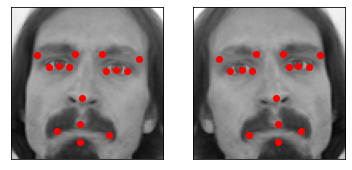

In [17]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [18]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [19]:
# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [20]:
# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)

Epoch 1/150
54/54 [==============================] - ETA: 0s - loss: 0.0043
Epoch 00001: val_loss improved from inf to 0.00192, saving model to best_weights.h5
54/54 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 2/150
51/54 [===========================>..] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00192 to 0.00185, saving model to best_weights.h5
54/54 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/150
53/54 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00003: val_loss improved from 0.00185 to 0.00180, saving model to best_weights.h5
54/54 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/150
50/54 [==========================>...] - ETA: 0s - loss: 9.3039e-04
Epoch 00004: val_loss improved from 0.00180 to 0.00163, saving model to best_weights.h5
54/54 [==============================] - 0s 9ms/step - loss: 9.1818e-04 - val_loss

Epoch 34/150
54/54 [==============================] - ETA: 0s - loss: 1.7681e-04
Epoch 00034: val_loss did not improve from 0.00062
54/54 [==============================] - 0s 8ms/step - loss: 1.7681e-04 - val_loss: 6.1681e-04
Epoch 35/150
49/54 [==========================>...] - ETA: 0s - loss: 1.7175e-04
Epoch 00035: val_loss did not improve from 0.00062
54/54 [==============================] - 0s 9ms/step - loss: 1.7166e-04 - val_loss: 6.4844e-04
Epoch 36/150
48/54 [=========================>....] - ETA: 0s - loss: 1.6668e-04
Epoch 00036: val_loss did not improve from 0.00062
54/54 [==============================] - 0s 9ms/step - loss: 1.6763e-04 - val_loss: 6.3387e-04
Epoch 37/150
50/54 [==========================>...] - ETA: 0s - loss: 1.6573e-04
Epoch 00037: val_loss improved from 0.00062 to 0.00061, saving model to best_weights.h5
54/54 [==============================] - 1s 11ms/step - loss: 1.6521e-04 - val_loss: 6.1109e-04
Epoch 38/150
47/54 [=========================>....] - 

Epoch 70/150
52/54 [===========================>..] - ETA: 0s - loss: 1.1042e-04
Epoch 00070: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 8ms/step - loss: 1.1013e-04 - val_loss: 6.0413e-04
Epoch 71/150
48/54 [=========================>....] - ETA: 0s - loss: 1.0769e-04
Epoch 00071: val_loss did not improve from 0.00058
54/54 [==============================] - 1s 9ms/step - loss: 1.0782e-04 - val_loss: 6.2710e-04
Epoch 72/150
52/54 [===========================>..] - ETA: 0s - loss: 1.0799e-04
Epoch 00072: val_loss did not improve from 0.00058
54/54 [==============================] - 1s 10ms/step - loss: 1.0791e-04 - val_loss: 6.1530e-04
Epoch 73/150
50/54 [==========================>...] - ETA: 0s - loss: 1.0811e-04
Epoch 00073: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 1.0818e-04 - val_loss: 6.1288e-04
Epoch 74/150
50/54 [==========================>...] - ETA: 0s - loss: 1.0405e-04
Epoch 0007

Epoch 106/150
47/54 [=========================>....] - ETA: 0s - loss: 8.6674e-05
Epoch 00106: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 8.6353e-05 - val_loss: 5.8484e-04
Epoch 107/150
50/54 [==========================>...] - ETA: 0s - loss: 8.5054e-05
Epoch 00107: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 8.5306e-05 - val_loss: 6.0334e-04
Epoch 108/150
49/54 [==========================>...] - ETA: 0s - loss: 8.8386e-05
Epoch 00108: val_loss did not improve from 0.00058
54/54 [==============================] - 1s 10ms/step - loss: 8.8465e-05 - val_loss: 5.9792e-04
Epoch 109/150
50/54 [==========================>...] - ETA: 0s - loss: 8.6970e-05
Epoch 00109: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 8ms/step - loss: 8.6770e-05 - val_loss: 6.0340e-04
Epoch 110/150
53/54 [============================>.] - ETA: 0s - loss: 8.4716e-05
Epoch

Epoch 142/150
50/54 [==========================>...] - ETA: 0s - loss: 8.0237e-05
Epoch 00142: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 7.9567e-05 - val_loss: 6.0654e-04
Epoch 143/150
49/54 [==========================>...] - ETA: 0s - loss: 7.9869e-05
Epoch 00143: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 7.9836e-05 - val_loss: 6.2903e-04
Epoch 144/150
51/54 [===========================>..] - ETA: 0s - loss: 7.7476e-05
Epoch 00144: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 9ms/step - loss: 7.7835e-05 - val_loss: 6.1541e-04
Epoch 145/150
52/54 [===========================>..] - ETA: 0s - loss: 7.8653e-05
Epoch 00145: val_loss did not improve from 0.00058
54/54 [==============================] - 0s 8ms/step - loss: 7.8583e-05 - val_loss: 6.0924e-04
Epoch 146/150
49/54 [==========================>...] - ETA: 0s - loss: 7.7162e-05
Epoch 

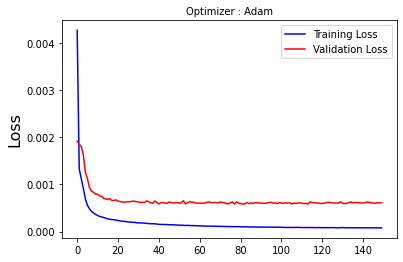

In [21]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

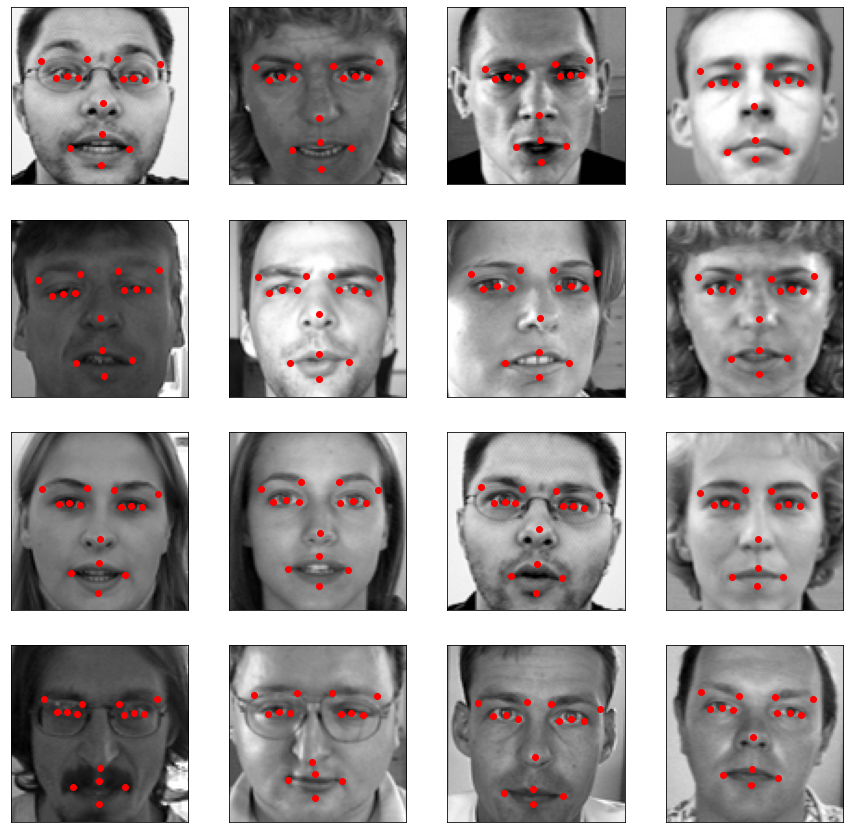

In [22]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))